<a href="https://colab.research.google.com/github/chukwukapromise/Tensorflow-object-detection-model/blob/main/pet_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!wget https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip

--2025-12-04 22:05:02--  https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.3.94.53, 2600:1402:8000:480::317f, 2600:1402:8000:48f::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.3.94.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M  97.0MB/s    in 12s     

2025-12-04 22:05:14 (67.6 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [ ]:
!unzip kagglecatsanddogs_5340.zip

In [ ]:
import os

# label the images
input_path = []
label = []

for class_name in os.listdir("PetImages"):
  for path in os.listdir("PetImages/"+class_name):
    if class_name == 'Cat':
      label.append(0)

    else:
      label.append(1)

    input_path.append(os.path.join("PetImages", class_name, path))
    print(input_path[0], label[0])

In [6]:
import pandas as pd

df = pd.DataFrame()
df['image'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,image,label
0,PetImages/Dog/9576.jpg,1
1,PetImages/Dog/6298.jpg,1
2,PetImages/Dog/1312.jpg,1
3,PetImages/Dog/1567.jpg,1
4,PetImages/Dog/11677.jpg,1


In [ ]:
# find images with error

import PIL
l = []
for image in df['image']:
  try:
    img = PIL.Image.open(image)
  except:
    l.append(image)

In [9]:
# delete images with error
df = df[df['image']!='PetImages/Dog/Thumbs.db']
df = df[df['image']!='PetImages/Cat/Thumbs.db']
df = df[df['image']!='PetImages/Cat/666.jpg']
df = df[df['image']!='PetImages/Dog/11702.jpg']

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np
from keras.preprocessing.image import load_img

# display instances for dogs
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['image']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
  plt.subplot(5,5,index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title("Dog")
  plt.axis('off')

# display instances for cats
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['image']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
  plt.subplot(5,5,index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title("Cat")
  plt.axis('off')

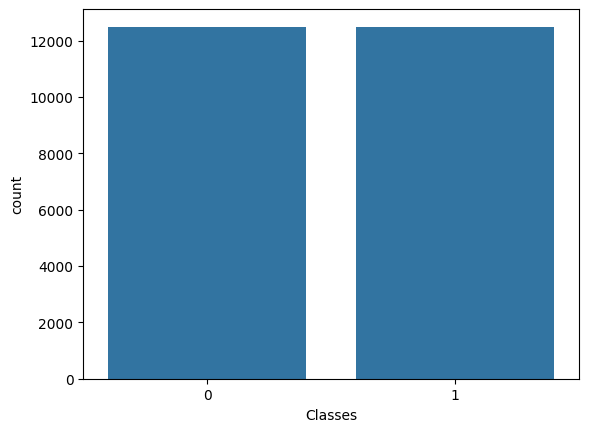

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# visualise the total number of images for each class
sns.countplot(x=df['label'])
plt.xlabel('Classes')
plt.show()

In [12]:
#stringify labels
df['label'] = df['label'].astype('str')

In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)
test.head()

,image,label
6868,PetImages/Dog/9171.jpg,1
22914,PetImages/Cat/3716.jpg,0
9668,PetImages/Cat/10326.jpg,0
13638,PetImages/Cat/2883.jpg,0
23341,PetImages/Cat/5986.jpg,0


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create image data generator
train_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

validation_generator = ImageDataGenerator(
    rescale = 1./255
)

train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col = 'image',
    y_col = 'label',
    target_size = (256,256),
    batch_size = 512,
    class_mode = 'binary'
)

validation_iterator = validation_generator.flow_from_dataframe(
    test,
    x_col = 'image',
    y_col = 'label',
    target_size = (256,256),
    batch_size = 512,
    class_mode = 'binary'
)

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# normalization and augmentation
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(256,256,3)),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# train the model
history = model.fit(train_iterator, epochs=5, validation_data=validation_iterator)

In [ ]:
# visualise model performance metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss graph')
plt.legend()
plt.figure()

In [ ]:
# save the model in hdf5
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/saved-model/model.hdf5')
print("Model saved")

In [ ]:
import tensorflow as tf

# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to a specified path in Google Drive
with open('/content/drive/MyDrive/saved-model/model.tflite', 'wb') as f:
  f.write(tflite_model)